In [286]:
import tdt
import numpy as np
import matplotlib.pyplot as plt
from warnings import warn 
from pathlib import Path
from tkinter import Tk
from tkinter import filedialog
from readSGLX import readMeta, SampRate, makeMemMapRaw, ExtractDigital
from sklearn.linear_model import LinearRegression
from scipy.io import savemat
from warnings import warn
from barcodes import extract_barcodes_from_times
from difflib import SequenceMatcher

In [137]:
def plot_pulses(onset_times, offset_times, nPulsesToPlot=20):
    '''Use onset and offset times to plot pulse waveforms. 
    Times should be in seconds. Plot only the first N pulses (default 100)'''
    
    #Interleave onset and offset times
    edge_times = np.empty((onset_times.size + offset_times.size,), dtype=onset_times.dtype)
    edge_times[0::2] = onset_times
    edge_times[1::2] = offset_times
    
    # Figure out when pulses are high and when they are low
    sync_levels = np.empty((onset_times.size + offset_times.size,), dtype=onset_times.dtype)
    sync_levels[0::2] = 1
    sync_levels[1::2] = 0

    plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.step(edge_times[:nPulsesToPlot], sync_levels[:nPulsesToPlot], where='post')

# Load SGLX

In [138]:
def select_sglx_file():
    '''Select a SGLX binary file to extract the digtial sync bit from. 
    Using the LFP file is faster, but the AP file is maximally precise.'''

    
    # Get file from user
    root = Tk()         # create the Tkinter widget
    root.withdraw()     # hide the Tkinter root window

    # Windows specific; forces the window to appear in front
    root.attributes("-topmost", True)

    fullPath = Path(filedialog.askopenfilename(title="Select SpikeGLX binary file"))

    root.destroy()
    
    return fullPath

In [139]:
def sglx_load_sync(sglx_file):
    '''Load the sync channel from the specified binary file. 
    The SpikeGLX metadata file must be present in the same directory as the binary file.'''
    meta = readMeta(sglx_file)
    rawData = makeMemMapRaw(sglx_file, meta)

    # Read the entire file
    firstSamp = 0
    lastSamp = rawData.shape[1]-1

    # Which digital word to read. 
    # For imec, there is only 1 digital word, dw = 0.
    # For NI, digital lines 0-15 are in word 0, lines 16-31 are in word 1, etc.
    dw = 0    
    # Which lines within the digital word, zero-based
    # Note that the SYNC line for PXI 3B is stored in line 6.
    dLineList = [6]
        
    return ExtractDigital(rawData, firstSamp, lastSamp, dw, dLineList, meta)

In [140]:
def sglx_onset_samples(sync):
    '''Extract the pulse rising edge samples from the SGLX sync channel.'''
    # Onsets are the first samples where a value is high after being low. If sample 0 is high, the first onset is sample 0. Consistent with TDT convention.
    onset_samples = np.where(np.diff(np.squeeze(sync), prepend=0) == 1)[0]
    assert(onset_samples.dtype == np.dtype('int64')) # Make sure uint8s have been properly casted as int64s
    return onset_samples

In [141]:
def sglx_offset_samples(sync):
    '''Extract the pulse falling edge samples from the SGLX sync channel'''
    # Offsets are the first samples wehre a value is low after being high. If the last sample is high, the last offset is Inf. Consistent with TDT convention.
    offset_samples = np.where(np.diff(np.squeeze(sync), prepend=0) == -1)[0]
    assert(offset_samples.dtype == np.dtype('int64')) # Make sure uint8s have been properly casted as int64s
    if np.squeeze(sync)[-1] == 1:
        offset_samples = np.append(offset_samples, np.Inf)
    return offset_samples

In [142]:
def get_rising_edges(onset_times):
    '''Assumes onset times follow TDT convention, as described above.'''
    return onset_times[np.where(onset_times > 0)]

In [143]:
def get_falling_edges(offset_times):
    '''Assumes offset times follow TDT convention, as described above '''
    return offset_times[np.where(offset_times < np.Inf)]

In [144]:
sglx_file = select_sglx_file()

In [145]:
sglx_sync = sglx_load_sync(sglx_file)
sglx_fs = SampRate(readMeta(sglx_file))
# Times are in seconds from the start of the SGLX recording. 
sglx_onset_times = sglx_onset_samples(sglx_sync) / sglx_fs
sglx_offset_times = sglx_offset_samples(sglx_sync) / sglx_fs

nChan: 385, nFileSamp: 4794576


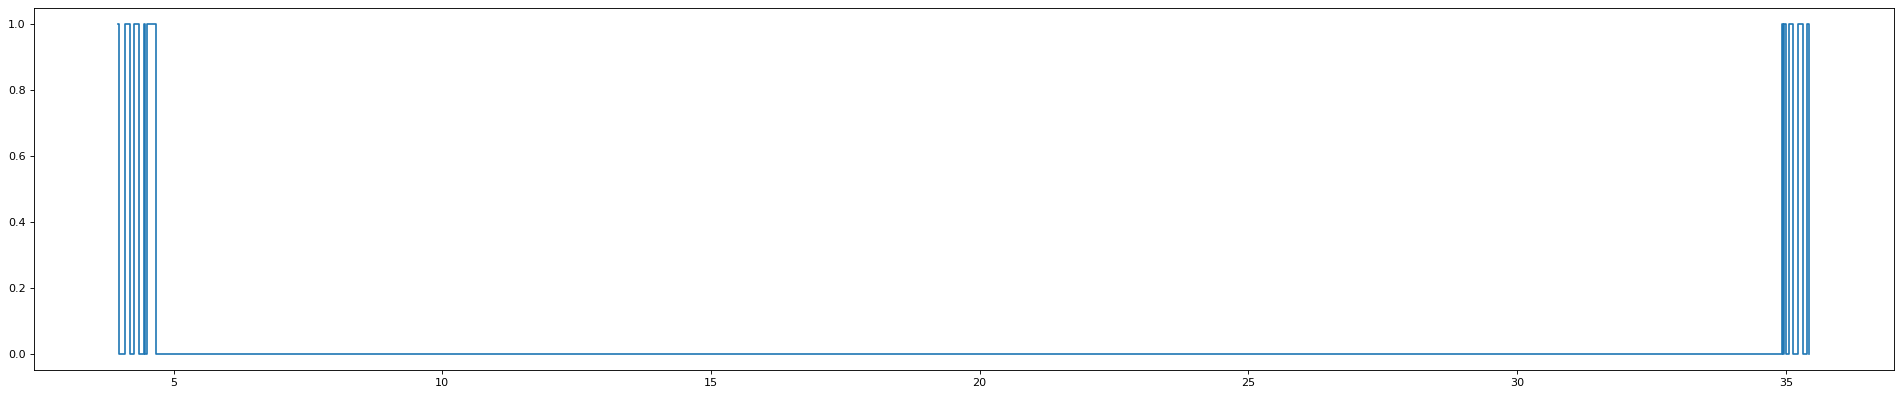

In [146]:
plot_pulses(sglx_onset_times, sglx_offset_times, nPulsesToPlot=20)

In [147]:
sglx_rising_edges = get_rising_edges(sglx_onset_times)
sglx_falling_edges = get_falling_edges(sglx_offset_times)
sglx_barcode_start_times, sglx_barcodes = extract_barcodes_from_times(sglx_rising_edges, sglx_falling_edges, bar_duration=0.029)

# Load TDT

In [148]:
def select_tdt_block():
    '''Select a TDT block to extract sync info from.'''
    # Get file from user
    root = Tk()         # create the Tkinter widget
    root.withdraw()     # hide the Tkinter root window

    # Windows specific; forces the window to appear in front
    root.attributes("-topmost", True)

    fullPath = Path(filedialog.askdirectory(title="Select TDT block"))

    root.destroy()
    
    return fullPath

In [149]:
tdt_file = select_tdt_block()

In [150]:
tdt_data = tdt.read_block(tdt_file, evtype=['epocs'])
# Here, we assume that your digital sync pulse is recorded on Port C0
# YSK: TDT calls the onset of a signal that starts high "0", but the offset of a signal that ends high "inf"
# Times are in seconds from the start of the TDT recording. 
tdt_onset_times = tdt_data.epocs.PC0_.onset 
tdt_offset_times = tdt_data.epocs.PC0_.offset

read from t=0s to t=1722.95s


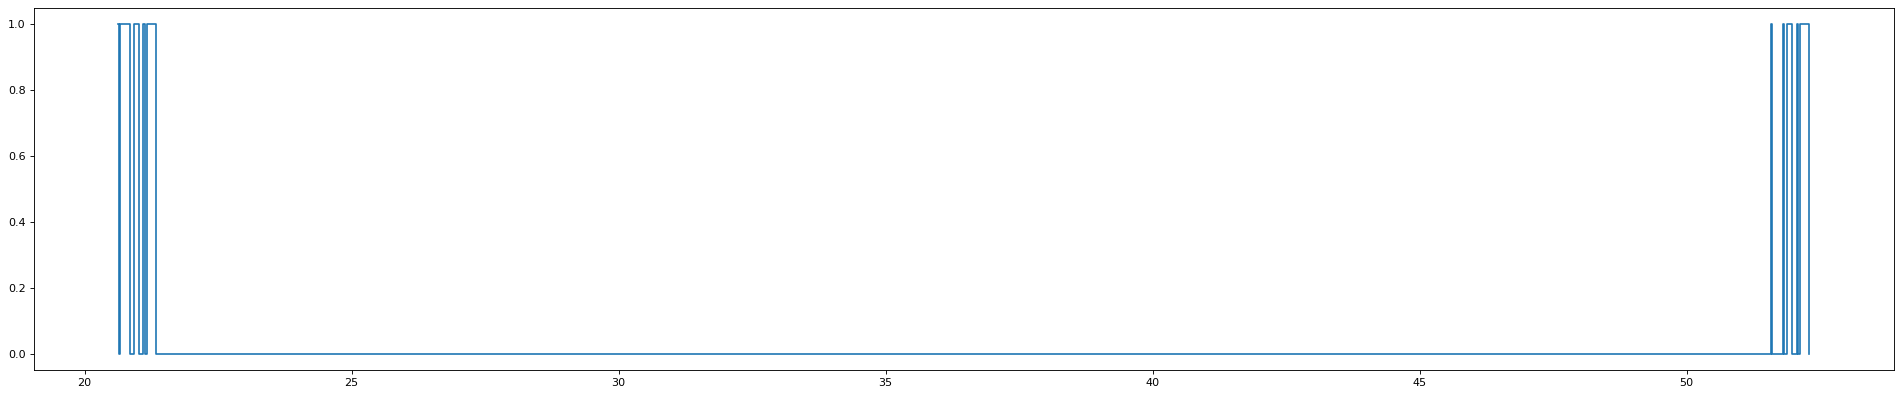

In [151]:
plot_pulses(tdt_onset_times, tdt_offset_times, nPulsesToPlot=20)

In [152]:
tdt_rising_edges = get_rising_edges(tdt_onset_times)
tdt_falling_edges = get_falling_edges(tdt_offset_times)
tdt_barcode_start_times, tdt_barcodes = extract_barcodes_from_times(tdt_rising_edges, tdt_falling_edges, bar_duration=0.029)

# Use barcodes to align streams

In [153]:
print(sglx_barcode_start_times)
print(tdt_barcode_start_times)

[  34.92521036   65.88281955   96.84042873  127.79843792  158.7560471
  189.71365629  220.67126548  251.62887466  282.58648385  313.54409303
  344.50170222  375.4593114   406.41692059  437.37452977  468.33213896
  499.28974814  530.24735733  561.20496651  592.1625757   623.12018488
  654.07779407  685.03540326  715.99301244  746.95062163  777.90823081
  808.86584     839.82344918  870.78105837  901.73866755  932.69627674
  963.65388592  994.61149511 1025.56910429 1056.52671348 1087.48432267
 1118.44193185 1149.39954104 1180.35715022 1211.31475941 1242.27236859
 1273.22997778 1304.18758696 1335.14519615 1366.10280533 1397.06041452
 1428.0180237  1458.97563289 1489.93364208 1520.89125126 1551.84886045
 1582.80646963 1613.76407882 1644.721688   1675.67929719 1706.63690637
 1737.59491556 1768.55252474 1799.51013393 1830.46774312 1861.4253523
 1892.38296149]
[  51.5833856    82.54099456  113.49864448  144.45625344  175.41382144
  206.3714304   237.32903936  268.28664832  299.24425728  330.2

In [157]:
print("SpikeGLX barcodes:\n", sglx_barcodes)
print("TDT barcodes:\n", tdt_barcodes)

SpikeGLX barcodes:
 [189325.0, 189323.0, 189321.0, 189319.0, 189317.0, 189315.0, 189313.0, 189311.0, 189309.0, 189307.0, 189305.0, 189303.0, 189301.0, 189299.0, 189297.0, 189295.0, 189293.0, 189291.0, 189289.0, 189287.0, 189285.0, 189283.0, 189281.0, 189279.0, 189277.0, 189275.0, 189273.0, 189271.0, 189269.0, 189267.0, 189265.0, 189263.0, 189261.0, 189259.0, 189257.0, 189255.0, 189253.0, 189251.0, 189249.0, 189247.0, 189245.0, 189243.0, 189241.0, 189239.0, 189237.0, 189235.0, 189233.0, 189231.0, 189229.0, 189227.0, 189225.0, 189223.0, 189221.0, 189219.0, 189217.0, 189215.0, 189213.0, 189211.0, 189209.0, 189207.0, 189205.0]
TDT barcodes:
 [189311.0, 189309.0, 189307.0, 189305.0, 189303.0, 189301.0, 189299.0, 189297.0, 189295.0, 189293.0, 189291.0, 189289.0, 189287.0, 189285.0, 189283.0, 189281.0, 189279.0, 189277.0, 189275.0, 189273.0, 189271.0, 189269.0, 189267.0, 189265.0, 189263.0, 189261.0, 189259.0, 189257.0, 189255.0, 189253.0, 189251.0, 189249.0, 189247.0, 189245.0, 189243.0, 189

In [173]:
# Find the longest sequence of barcodes recorded by both systems
s = SequenceMatcher(None, sglx_barcodes, tdt_barcodes)
match = s.find_longest_match(alo=0, ahi=len(sglx_barcodes), blo=0, bhi=len(tdt_barcodes))
shared_barcodes = sglx_barcodes[match.a : match.a + match.size]
print("Longest barcode sequence common to both systems:\n", shared_barcodes)

Longest barcode sequence common to both systems:
 [189311.0, 189309.0, 189307.0, 189305.0, 189303.0, 189301.0, 189299.0, 189297.0, 189295.0, 189293.0, 189291.0, 189289.0, 189287.0, 189285.0, 189283.0, 189281.0, 189279.0, 189277.0, 189275.0, 189273.0, 189271.0, 189269.0, 189267.0, 189265.0, 189263.0, 189261.0, 189259.0, 189257.0, 189255.0, 189253.0, 189251.0, 189249.0, 189247.0, 189245.0, 189243.0, 189241.0, 189239.0, 189237.0, 189235.0, 189233.0, 189231.0, 189229.0, 189227.0, 189225.0, 189223.0, 189221.0, 189219.0, 189217.0, 189215.0, 189213.0, 189211.0, 189209.0, 189207.0, 189205.0]


In [176]:
# Using the barcodes shared by both systems, fit the TDT barcode times to the SGLX barcode times
y = sglx_barcode_start_times[match.a : match.a + match.size]
x = tdt_barcode_start_times[match.b : match.b + match.size].reshape((-1, 1))
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)

In [177]:
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('drift rate in msec/hr:', (model.coef_[0] - 1)*60*60*1000)

coefficient of determination: 0.9999999999999706
intercept: 200.04545206469015
drift rate in msec/hr: 1.1617149130671578


In [182]:
def visualize_mapping(sglx_rising_edges, tdt_rising_edges, model, nPulsesToPlot=10):
    '''Visualize remapped TDT sync pulse times in SGLX time space, to verify correctness.
    Black lines = Pulse times measured by SGLX.
    Red lines = Pulse times measured by TDT and remapped to SGLX time space. '''
    remapped_tdt_times = model.predict(tdt_rising_edges.reshape((-1, 1)))
    
    plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.vlines(sglx_rising_edges[:nPulsesToPlot], 0, 1, colors='black')
    plt.vlines(remapped_tdt_times[:nPulsesToPlot], 0, 1, linestyle='dotted', colors='red')

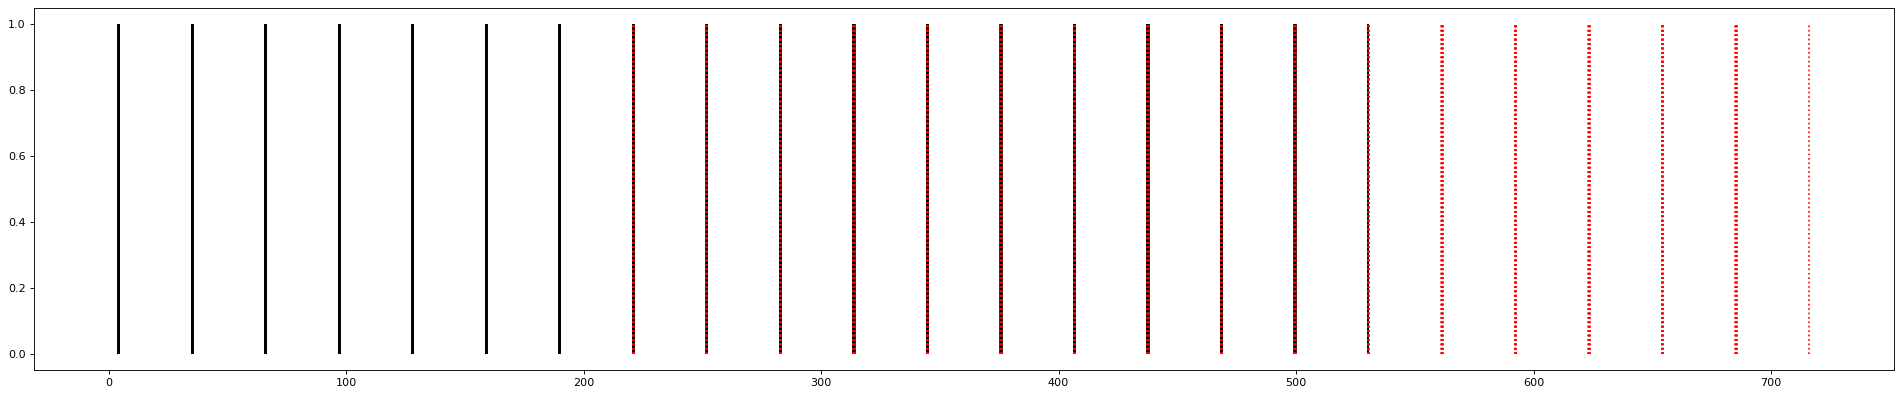

In [186]:
visualize_mapping(sglx_rising_edges, tdt_rising_edges, model, nPulsesToPlot=100)

# Get TDT stimulation times from epocs store. Best if ISI is fixed. 

In [455]:
def get_stim_times_from_epocs(tdt_data):
    '''Extract the time of each stimulation from a loaded TDT block.
    Times are in seconds from the start of the TDT recording.
    Only works if pulses are delivered at fixed intervals.'''
    CntA = tdt_data.epocs.CntA 
    PeA_ = tdt_data.epocs.PeA_
    
    n_strobes = np.size(PeA_.onset) 
    stim_t = np.array([])
    
    for strobe in np.arange(n_strobes):
        strobe_ISI = PeA_.data[strobe] / 1000 # Convert from msec to sec
        n_strobe_stims = CntA.data[strobe] # The number of stimlations in this strobe
        strobe_start = PeA_.onset[strobe] # The time that this strobe started
        strobe_stims = strobe_start + np.arange(n_strobe_stims) * strobe_ISI # The time of each stimulation in this strobe
        stim_t = np.append(stim_t, strobe_stims)
        
    return stim_t  

In [82]:
tdt_data = tdt.read_block(tdt_file, evtype=['epocs', 'streams'])
stim_times = get_stim_times(tdt_data)

read from t=0s to t=4833.03s


In [456]:
def visualize_stims_from_epocs(tdt_data, ch, first_stim=0, last_stim=4, before=100, after=100):
    '''Visualize estimated stimulation times (block dotted lines) relative to the stimulator current stream.
    first_stim is the 0-based index of the first stimulation to plot.
    last_stim is the 0-based index of the last stimulation to plot. 
    before/after are the number of samples to plot before the first stim and after the last stim.
    ch is the stimulator current channel to plot.'''
    fs = tdt_data.streams.eS1r.fs
    stim_times = get_stim_times_from_epocs(tdt_data)
    stim_samples = np.rint(stim_times * fs).astype('int')
    samplesToPlot = np.arange(stim_samples[first_stim] - before, stim_samples[last_stim] + after)

    plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(samplesToPlot, tdt_data.streams.eS1r.data[ch, samplesToPlot])
    plt.vlines(stim_samples[first_stim : last_stim + 1], 0, 1000, linestyle='dotted', colors='black')

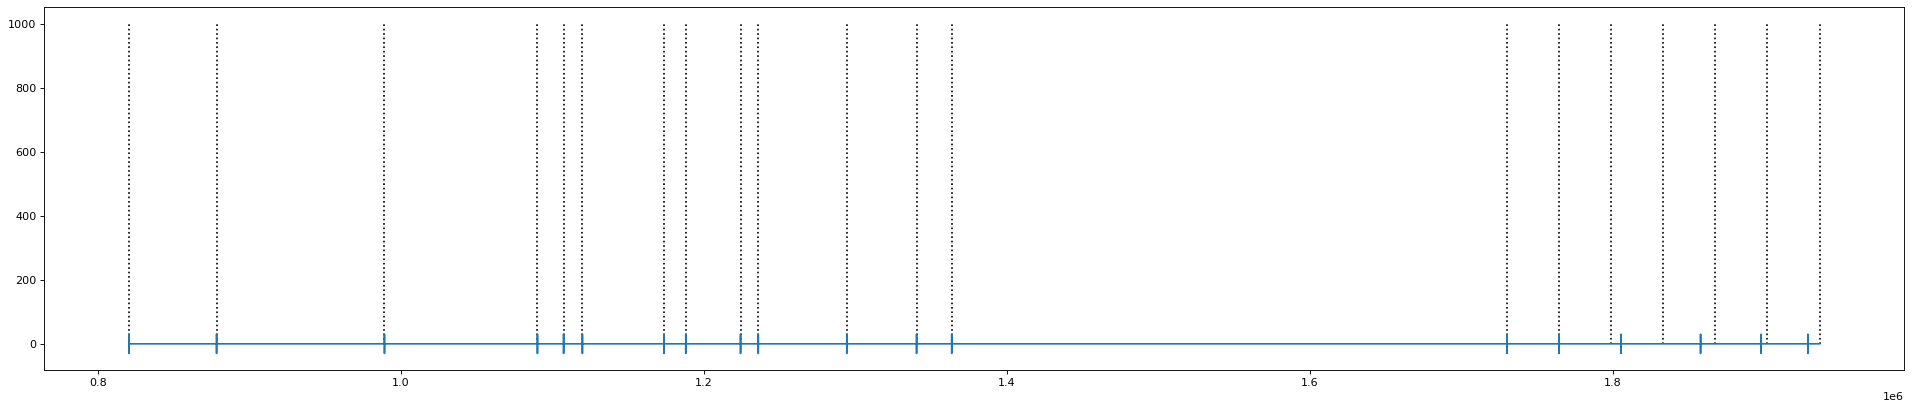

In [457]:
visualize_stims_from_epocs(tdt_data, ch=0, first_stim=1, last_stim=20)

# Get TDT stimulation times from streams store. Necessary if ISI is jittered.

In [187]:
def remove_trailing_events(events, fs, distance=0.01):
    """Remove events that trail the first event within a certain amount of time.
    
    Parameters:
    ===========
    events: (n_events,)
        The sample numbers of each event. 
    fs:
        The sample rate.
    distance:
        The minimum number of seconds that an event must trail its predecessor in order to avoid being removed.
    
    Returns:
    ========
    arr: (n,):
        All events which did not trail another event by less than `distance` seconds.
    
    Examples:
    =========
    If events are samples that occur at times (0.1, 0.4, 1, 1.9, 3) and distance=1,
        resulting samples be will be from times (0.1, 1.9, 3).
    """
    if events.size == 0:
        return []

    leading = [events[0]]
    trailing = np.where(events - events[0] <= int(fs * distance))
    remaining = np.delete(events, trailing)
    return leading + remove_trailing_events(remaining, fs, distance)

In [188]:
def assert_all_equal(arr):
    """Assert that all values in an array are equal, then return that value."""
    val = arr[0]
    assert np.all(arr == val), "All array values should be equal."
    return val

In [295]:
def get_stim_times_from_streams(tdt_data, isi_floor=0.01):
    """Get stimulation times by detecting the leading edges in the rectified, idealized current traces.
    Note that idealized current is found in the eS1r stream store, while the actual current is found
    in the IZ2n stream store. 
    
    Parameters:
    ===========
    tdt_data: TDT block with epocs and streams stores. 
    isi_floor:
        The mimimum interstimulation interval. This value must be longer than the duration of any single stimulation pulse. 
        
    Returns:
    ========
    times: (n_stimulations,)
        Stimulation times, in seconds from the start of the TDT recording.
    """
    fs = tdt_data.streams.eS1r.fs
    
    # Get the channel number for each of the bipolar stimulation channels
    chA = assert_all_equal(tdt_data.epocs.ChnA.data)
    chB = assert_all_equal(tdt_data.epocs.ChnB.data)
    
    # Get the corresponding indexes into the idealized current trace data.
    iA = np.where(tdt_data.streams.eS1r.channel == chA)[0][0]
    iB = np.where(tdt_data.streams.eS1r.channel == chB)[0][0]
    
    # Get the rectified, idealized current traces for each stimulatin channel.
    datA = np.abs(tdt_data.streams.eS1r.data[iA])
    datB = np.abs(tdt_data.streams.eS1r.data[iB])
    
    # This is the maximum pulse amplitude delivered.
    max_pulse_amp = tdt_data.epocs.AmpA.data.max()
    
    # TDT gives nonsense current trace values until the first pulse is delivered. Remove these. 
    datA[datA > max_pulse_amp] = 0
    datB[datB > max_pulse_amp] = 0

    assert np.isin(datA, [0, max_pulse_amp]).all(), "Unexpected values in eS1r. All pulse amplitudes should be the same."
    assert np.isin(datB, [0, max_pulse_amp]).all(), "Unexpected values in eS1r. All pulse amplitudes should be the same."

    # Get all samples from both channels where current is nonzero. 
    events = np.sort(np.concatenate(np.where(datA) + np.where(datB)))
    # Get the first sample (on either channel) where each pulse's current is nonzero.
    stim_samples = remove_trailing_events(events, fs, distance=isi_floor)
    
    n_stims_detected = len(stim_samples)
    n_stims_expected = tdt_data.epocs.CntA.data.sum()
    if(n_stims_detected != n_stims_expected):
        warn(f'Expected {n_stims_expected} stimulations, found {n_stims_detected}.', stacklevel=2)
    
    return stim_samples / fs

In [ ]:
tdt_data = tdt.read_block(tdt_file, evtype=['epocs', 'streams'])
stim_times = get_stim_times_from_streams(tdt_data)

In [246]:
def visualize_stims_from_streams(tdt_data, ch, first_stim=0, last_stim=4, before=100, after=100):
    '''Visualize estimated stimulation times (block dotted lines) relative to the stimulator current stream.
    first_stim is the 0-based index of the first stimulation to plot.
    last_stim is the 0-based index of the last stimulation to plot. 
    before/after are the number of samples to plot before the first stim and after the last stim.
    ch is the stimulator current channel to plot.'''
    fs = tdt_data.streams.eS1r.fs
    stim_samples = np.rint(get_stim_times_from_streams(tdt_data) * fs).astype('int')
    samplesToPlot = np.arange(stim_samples[first_stim] - before, stim_samples[last_stim] + after)

    plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(samplesToPlot, tdt_data.streams.eS1r.data[ch, samplesToPlot])
    plt.vlines(stim_samples[first_stim : last_stim + 1], 0, 1000, linestyle='dotted', colors='black')

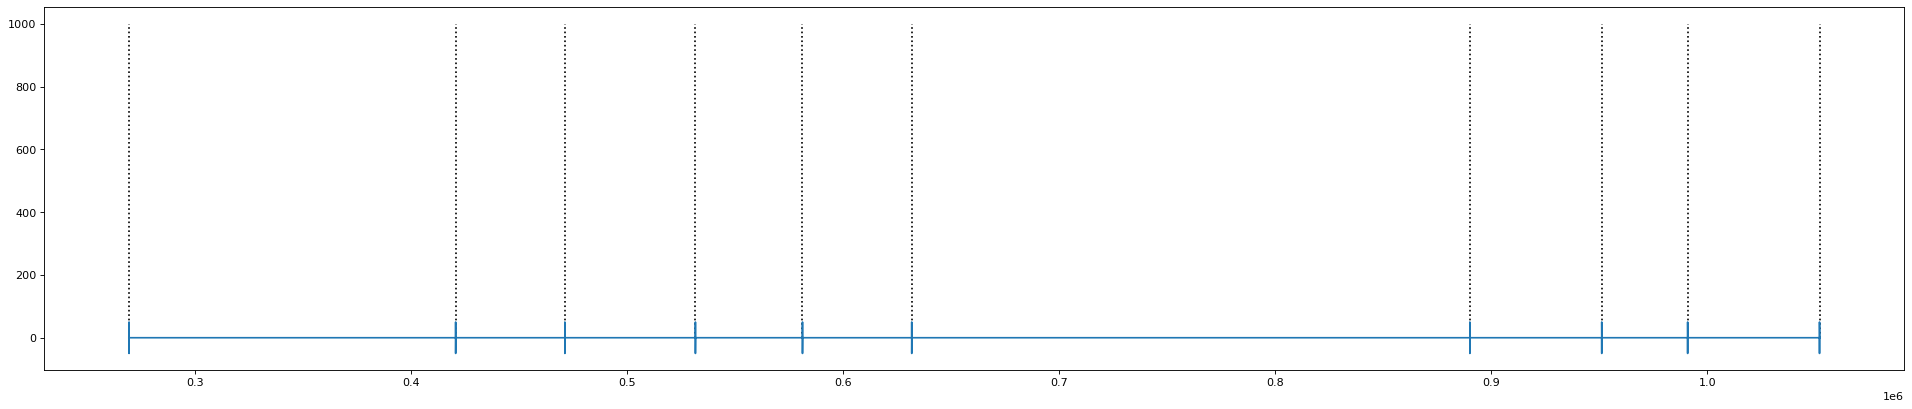

In [284]:
visualize_stims_from_streams(tdt_data, ch=0, first_stim=1, last_stim=10)

# Remap stimulation times from TDT space to SGLX space, and save. 

In [567]:
# Remap the stimulation times from TDT time space to SGLX time space, based on sync signal offset and drift between the two systems. 
sglx_stim_times = model.predict(stim_times.reshape((-1, 1)))
sglx_stim_times

array([  95.82592185,  134.02096689,  143.49550862,  161.65586612,
        178.20239925,  181.03289975,  183.06451622,  191.89680499,
        194.2469265 ,  200.17138228,  202.08765536,  211.66279487,
        219.21156079,  223.01330503,  283.07280316,  288.70824511,
        295.41913307,  304.01385379,  310.5645062 ,  315.61864369,
        321.4274284 ,  328.72584674,  336.76973725,  342.40157472,
        348.81427381,  355.41276751,  363.05164544,  368.57567617,
        377.44368207,  386.44439841,  393.64058056,  401.95480713,
        410.11076423,  415.35921601,  423.93624201,  430.20508954,
        439.11634922,  446.65200793,  454.63855443,  462.51074058,
        468.48402069,  475.06154286,  482.25444821,  489.65477505,
        495.14177793,  500.446263  ,  507.30559004,  515.05555152,
        520.98033498,  529.86505257,  537.48721882,  543.07875164,
        548.8275709 ,  556.66862744,  564.53262159,  569.46944962,
        578.00682632,  585.93144129,  592.92249571,  601.11023

In [67]:
def matlab_saveas_dialog():
    # Get file from user
    root = Tk()         # create the Tkinter widget
    root.withdraw()     # hide the Tkinter root window

    # Windows specific; forces the window to appear in front
    root.attributes("-topmost", True)

    fullPath = Path(filedialog.asksaveasfilename(title="Save as", defaultextension=".mat", filetypes=(("MATLAB", "*.mat"),)))

    root.destroy()
    
    return fullPath

In [ ]:
# Export the results for use in MATLAB. 
# The names of the SGLX and TDT files used are saved with the data. 
matlab_file = matlab_saveas_dialog()
savemat(matlab_file, {'sglx_stim_times': sglx_stim_times, 'sglx_file': sglx_file.name, 'tdt_file': tdt_file.name})